# Bike demand 

## Description

The following case study represents an Exploratory data analysis (EDA) as well as predictive modelling of the data on bycicle sharing. 

The EDA has shown that the data is not normally distributed and number of features are strongly inter-correlated. The missing timestamps in the data set were recovered and the features were updated accordingly. 

In addition, external data from the bike-sharing service web-page (https://www.capitalbikeshare.com/system-data) were used in constructing new features (`number of bike stations` and `extended membership`). Those turned out to be effective in model training and allowed to rule out the `year` from the list of training features. The `nStations` and `nBikes` are estimations, drawn from the external data, however in real-world business case it is assumed, that a user/client has the exat numbers available from business, and those numbers ae to be used instead.

Overall careful feature selection, based on the correlation studies, was performed. The set of selected features was restricted to be not large, requiring only necessary and easy-to-get data, such that the model would be rapid, not demanding and easy to use in business conditions.

The data set falls into the category of Time Series, hence the regular `k-fold` Cross-Validation (CV) is not suitable. For the CV the so-called `Nested CV` of 8 folds was chosen. 

For the data modelling four different models were considered: `LinearRegression`, `Ridge`, `DecisionTreeRegression` and the ensemble of decision trees, i.e. `RandomForestRegressor` (`n_estimators = 100`). The decision-tree-based models were restricted to `max_depth = 10`. The `MAE` was used as a quality criterion. The tree-based models performed significantly better, but the `RandomForestRegression` took way too much time for training, which is not suitable for the business usage. The `DecisionTreeRegression` was chosen as the best model, well suited for the set task.

The Decision Tree `MAE` ended up  **~45-65** depending on the fold of the train/test split. Finally the model was trained on the full 2011-2012 data set and saved via `Pickle`.

In addition, external data on the year 2013 from the bike-sharing service web-page was used to validate the performance of the chosen model. Regardless of the simplistic assumptions on the temperature and number of bike stations, the model performed well on the Jan-Feb 2013 data and the `MAE` came to be **~68**. 

A simple Flask API was fashioned as an example of the model usage. The API returns the predicted amount of bikes in response to the given data.

## Outlook

Assuming that the input data might be much larger than that of the present case study, it might become problematic to use the setup in its current state. To process large amounts of data one would need to be able to either start using a really powerful machine for the computations or parallelise computing in order to avoid problems with lack of memory or unrealstically long training of the model. There are several ways to overcome such problems such as using cloud services or machines with bigger memory/CPU, using Spark or other parallelization frameworks. 


# Outline
1. [Data preparation](#Section_1)

2. [Exploratory data analysis](#Section_2)
  * [Target over time](#Target_over_time)
  * [Missing timestamps](#Missing_timestamps)
  * [Features from external sources](#Features_from_external_sources)
  * [Feature correlation studies](#Feature_correlation_studies)

3. [Predictive analysis](#Section_3)
  * [Nested cross-validation](#Nested_cross_validation)
  * [Model training](#Model_training)
  * [Model validation](#Model_validation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import datetime as dt
import pickle
import glob

from sklearn.model_selection import (TimeSeriesSplit, cross_validate)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import (LinearRegression, Ridge)
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

import warnings                   
warnings.filterwarnings('ignore')

<a id='Section_1'></a>
# Data preparation

Read both hour and day data sets.

In [2]:
def read_csv(path):
    all_files = glob.glob(path + '/*.csv')
    file_list = []

    for filename in all_files:
        df_ = pd.read_csv(filename, index_col = None, header = 0)
        file_list.append(df_)

    df_read = pd.concat(file_list, axis = 0, ignore_index = True)
    
    return df_read

In [3]:
path_hour = r'Bike-Sharing-Dataset/hour'
path_day = r'Bike-Sharing-Dataset/day'

df_hour = read_csv(path_hour)
df_day = read_csv(path_day)

Check for duplicates.

In [4]:
df_hour.loc[df_hour.duplicated()]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [5]:
df_day.loc[df_day.duplicated()]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


Check for missing values

In [6]:
df_hour.isnull().values.any()

False

In [7]:
df_day.isnull().values.any()

False

Check that types make sense.

In [8]:
df_hour.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

The feature dteday needs to be cast into type `datetime` 

In [9]:
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])
df_day['dteday'] = pd.to_datetime(df_day['dteday'])

The feature `instant` does not carry any valuable information and nedds to be dropped.

In [10]:
df_hour.drop(['instant'], axis = 1, inplace = True)
df_day.drop(['instant'], axis = 1, inplace = True)

<a id='Section_2'></a>
# Exploratory data analysis

In [11]:
df_hour.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Check if the `registered` and `casual` are the exact two components of the target `cnt`.

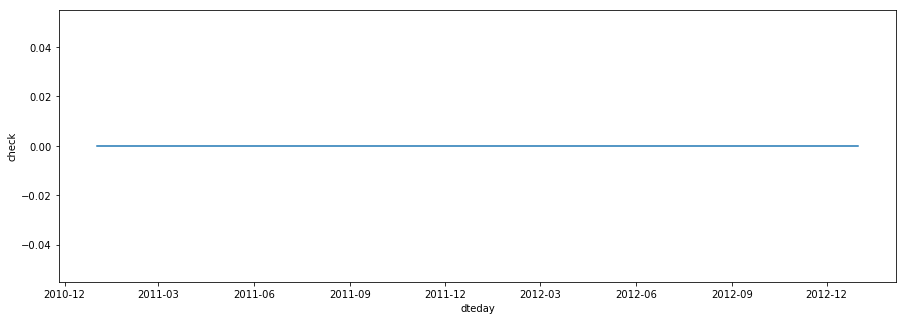

In [12]:
df_day['check'] = df_day['registered'] + df_day['casual'] - df_day['cnt']

plt.figure(figsize=(15,5))
sns.lineplot(data = df_day, x = 'dteday', y = 'check')

df_day.drop(['check'], axis = 1, inplace = True)

Study the target distribution.

Text(0.5,0,'Rents')

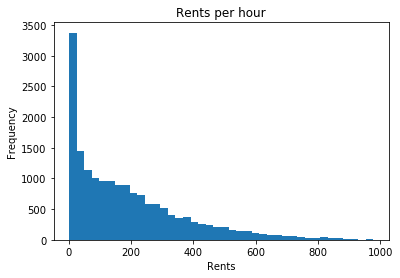

In [13]:
df_hour['cnt'].plot('hist', bins = 40)
plt.title('Rents per hour')
plt.xlabel('Rents')

The target `cnt` is distributed not normally.

This means that a simple linear regression would not be optimal in this case, as it requires normally distributed data.

<a id='Target_over_time'></a>
## Target over time 

Let's study the distribution of the target `cnt` over time. We will use the aggregated per-day data.

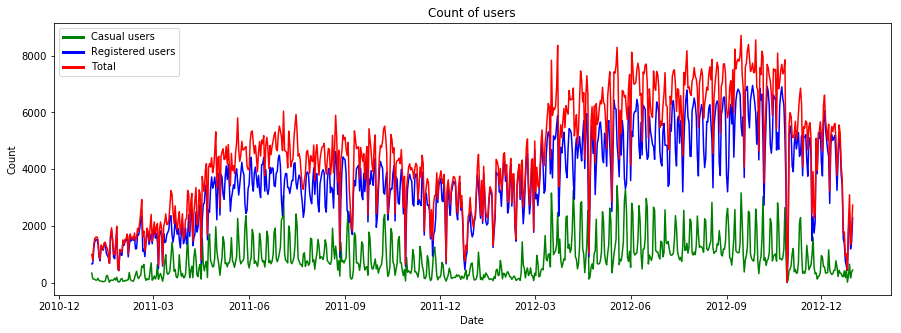

In [14]:
plt.figure(figsize=(15,5))

sns.lineplot(data = df_day, x = 'dteday', y = 'casual', color = 'green')
sns.lineplot(data = df_day, x = 'dteday', y = 'registered', color = 'blue')
sns.lineplot(data = df_day, x = 'dteday', y = 'cnt', color = 'red')

plt.title('Count of users')
plt.xlabel('Date')
plt.ylabel('Count')

labels = ['Casual users', 'Registered users', 'Total']
colors = ['green', 'blue', 'red']
lines = [Line2D([0], [0], color = c, linewidth = 3, linestyle = '-') for c in colors]
plt.legend(lines, labels, loc = 'upper left')

plt.show()

The distribution **shows well pronounced seasonality** and also **reflects force majeure events**, such as Sandy hurricane in the end of October 2012 (see the sudden drop in the distribution).

Registered user counts are systematically higher then the counts for the casuals.

In addition, there are **more users in the year 2012**. Number of registered-user counts increase. Also number of casual users grow slightly. The reason might be growth of popularity and/or availability of the service.

<a id='Missing_timestamps'></a>
## Missing timestamps

Let's check if all the timestemps are present.

In [15]:
base_time = dt.datetime(2011, 1, 1, 0)
end_time = dt.datetime(2012, 12, 31, 23)
seconds_in_hour = 3600
nHours = int((end_time - base_time).total_seconds() / seconds_in_hour)
nHours

17543

In [16]:
df_hour.shape

(17379, 16)

Some of the hours are absent (perhaps due to no bike usage).

In [17]:
base_time = dt.datetime(2011, 1, 1, 0)
stamp_list = [base_time + dt.timedelta(seconds = x * seconds_in_hour) for x in range(nHours)]

In [18]:
df_hour['timestamp'] = [dt.datetime(date.year, 
                                    date.month,
                                    date.day, 
                                    df_hour['hr'][i]) for i, date in enumerate(df_hour['dteday'])]

In [19]:
df_hour.index = pd.DatetimeIndex(df_hour.timestamp)

In [20]:
marker = 99999
df_hour = df_hour.reindex(stamp_list, fill_value = marker)

In [21]:
df_hour.drop(['timestamp'], axis = 1, inplace = True)
df_hour.reset_index(inplace = True)

In [22]:
def replace_from_last(df, feature_list, marker, replace):
    for feature in feature_list:
        for i, value in enumerate(df[feature]):
            if value == marker:
                if replace == True:
                    df_hour[feature][i] = df_hour[feature][i - 1]
                else:
                    df_hour[feature][i] = 0
    return df

In [23]:
feature_list_rep = ['temp', 'atemp', 'hum', 'windspeed', 'season', 'holiday', 'weathersit']
feature_list_zero = ['casual', 'registered', 'cnt']

df_hour = replace_from_last(df_hour, feature_list_rep, marker, True)
df_hour = replace_from_last(df_hour, feature_list_zero, marker, False)

In [24]:
df_hour['yr'] = [int(stamp.year != 2011) for stamp in df_hour['timestamp']]
df_hour['mnth'] = [stamp.month for stamp in df_hour['timestamp']]
df_hour['hr'] = [stamp.hour for stamp in df_hour['timestamp']]
df_hour['weekday'] = [stamp.weekday() for stamp in df_hour['timestamp']]
df_hour['workingday'] = [int(date.isoweekday() < 6) for date in df_hour['dteday']]

df_hour['dteday'] = pd.DatetimeIndex(df_hour['timestamp']).normalize()

<a id='Features_from_external_sources'></a>
## Features from external sources

On the official web-page of the bike-sharing service (https://www.capitalbikeshare.com/system-data) there is info on the changes in membership policy: in Fall 2011 3-day membership has been replaced by 5-day membership. This might make a good categorical feature.

In [25]:
policy_change = dt.datetime(2011, 9, 1)
df_hour['ext_membership'] = [int(date > policy_change) for date in df_hour['dteday']]

On the web-page of the bike-sharing service *raw data files of the bike usage* are given for *each year*. This allows to estimate the **number of available bikes** in the service as well as the **number of existing bike stops**.

In [26]:
path_raw_2011 = r'2011-capitalbikeshare-tripdata'
path_raw_2012 = r'2012-capitalbikeshare-tripdata'

df_raw_11 = read_csv(path_raw_2011)
df_raw_12 = read_csv(path_raw_2012)

In [27]:
df_raw_11.loc[df_raw_11.duplicated()]

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type


In [28]:
df_raw_12.loc[df_raw_12.duplicated()]

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type


In [29]:
df_raw_11.isnull().values.any()

False

In [30]:
df_raw_12.isnull().values.any()

False

In [31]:
df_raw_11 = df_raw_11.sort_values('Start date')
df_raw_12 = df_raw_12.sort_values('Start date')

In [32]:
df_raw_11['Start date'] = pd.to_datetime(df_raw_11['Start date'])

df_raw_12['Start date'] = pd.to_datetime(df_raw_12['Start date'])

In [33]:
df_raw_11['date'] = pd.DatetimeIndex(df_raw_11['Start date']).normalize()
df_raw_11['month'] = [date.month for date in df_raw_11['date']]
df_raw_11['year'] = [date.year for date in df_raw_11['date']]

df_raw_12['date'] = pd.DatetimeIndex(df_raw_12['Start date']).normalize()
df_raw_12['month'] = [date.month for date in df_raw_12['date']]
df_raw_12['year'] = [date.year for date in df_raw_12['date']]

In [34]:
def extract_unique(df_list, group_feature_list, unique_entity, feature_name):
    frame_list = []
    
    for df in df_list:
        df_ = df.groupby(group_feature_list)[unique_entity].unique()    
        df_ = df_.to_frame().reset_index()
        df_[feature_name] = [len(entity_list) for entity_list in df_[unique_entity]]
        df_.drop([unique_entity], axis = 1, inplace = True)

        frame_list.append(df_)
    
    df_nUnique = pd.concat(frame_list)
    df_nUnique = df_nUnique.reset_index(drop = True)
    
    return df_nUnique

In [35]:
df_nBikes = extract_unique([df_raw_11, df_raw_12], ['month', 'year'], 'Bike number', 'nBikes')
df_nStations = extract_unique([df_raw_11, df_raw_12], ['month', 'year'], 'Start station', 'nStations')

In [36]:
df_nBikes = df_nBikes.replace([2011, 2012], [0, 1])
df_nStations = df_nStations.replace([2011, 2012], [0, 1])

In [37]:
X_bikes = df_nBikes[['month', 'year']]
Y_bikes = df_nBikes['nBikes']

In [38]:
lr_bikes = LinearRegression()

In [39]:
res_bikes = lr_bikes.fit(X_bikes, Y_bikes)
pred = res_bikes.predict(X_bikes)

r2_score(pred, Y_bikes)

0.9456850192181978

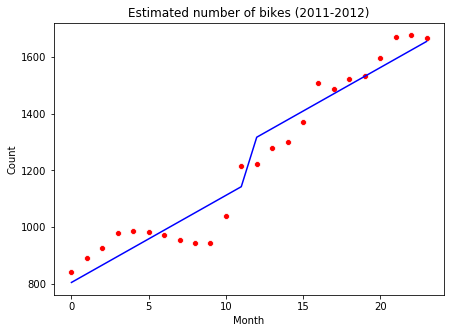

In [40]:
plt.figure(figsize = (7, 5))

sns.lineplot(data = Y_bikes, color = 'red', marker = 'o', linewidth = 0)
sns.lineplot(data = pred, color = 'blue')

plt.title('Estimated number of bikes (2011-2012)')
plt.ylabel('Count')
plt.xlabel('Month')

plt.show()

In [41]:
X_stations = df_nStations[['month', 'year']]
Y_stations = df_nStations['nStations']

In [42]:
lr_stations = LinearRegression()

In [43]:
res_stations = lr_stations.fit(X_stations, Y_stations)
pred = res_stations.predict(X_stations)

r2_score(pred, Y_stations)

0.9604541644601868

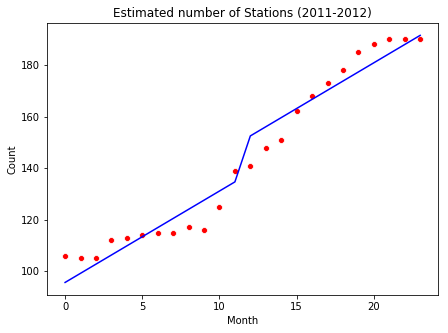

In [44]:
plt.figure(figsize = (7, 5))

sns.lineplot(data = Y_stations, color = 'red', marker = 'o', linewidth = 0)
sns.lineplot(data = pred, color = 'blue')

plt.title('Estimated number of Stations (2011-2012)')
plt.ylabel('Count')
plt.xlabel('Month')

plt.show()

In [45]:
df_hour['nBikes'] = res_bikes.predict(df_hour[['mnth', 'yr']]).tolist()
df_hour['nStations'] = res_stations.predict(df_hour[['mnth', 'yr']]).tolist()

<a id='Feature_correlation_studies'></a>
## Feature correlation studies

Let's study the correlations of the potential features to the target as well as inter-correltions.

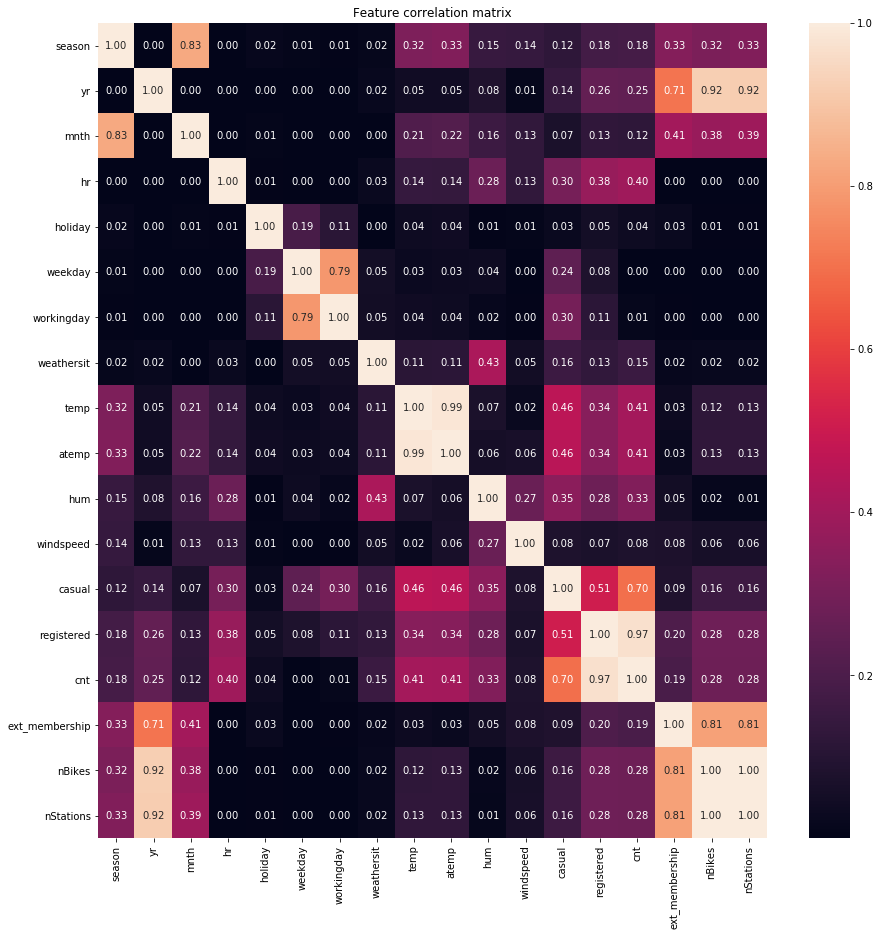

In [46]:
corr = df_hour.corr().abs()
plt.figure(figsize = (15, 15))
sns.heatmap(corr, annot = True, fmt='.2f')

plt.title('Feature correlation matrix')
plt.yticks(rotation=0) 

plt.show()

In [47]:
corr_cas = corr['cnt']
corr_cas[corr_cas < 0.1].sort_values()

weekday       0.001837
workingday    0.013377
holiday       0.036125
windspeed     0.081616
Name: cnt, dtype: float64

The features of low correlation with the target have small potential to contribute to the predictive analysis. Besides, having plenty of useless features may "confuse" the model and cause a need for additional computational powers.

In [48]:
df_hour[['temp', 'atemp', 'mnth', 'season']].corr().abs()

,temp,atemp,mnth,season
temp,1.000000,0.987761,0.210425,0.318459
atemp,0.987761,1.000000,0.217510,0.326325
mnth,0.210425,0.217510,1.000000,0.831665
season,0.318459,0.326325,0.831665,1.000000


Featute `temp` is highly correlated to the `atemp`, as well as `mnth` is correlated to the `season`.
In the predictive analysis it makes sense to use only one feature of the correlated couple.

In [49]:
df_hour[['temp', 'atemp', 'mnth', 'season']].var().sort_values()

atemp      0.029745
temp       0.037293
season     1.232217
mnth      11.899046
dtype: float64

The features with the higher variance are normally favored in the analysis. This makes  `temp` and `mnth` preferred features.

The new features `nBikes` and `nStations` are fully correlated, wich may be axplained that new bikes were added to the system with new stations. We will use only `nStations` of these two, as the score for it was higher. `nStations` is also highly correlated to the feature `yr`, which allows us to use only `nStations` in the modelling. It makes sense more to **train a model on numbers of stations provided by business** than on simple calendar variable.

In principle, **for the business case the simplicity of the model is crucial**. This means, **the less parameters are needed for a reliable and fast prediction, the better**. Besides, the input parameters need to be relatively easy to obtain. The details on the weather as humidity, windspeed etc. are not so easy to obtain and are not as important for the target either. We will follow the **strategy of using only temperature as a weather feature**
 for the future model, as it shows relatively high correlation to the target and is relatively easy to predict/assume.


<a id='Section_3'></a>
# Predictive analysis

Select the target and features according to the findings in the EDA.

In [50]:
Y = df_hour['cnt']

features = ['mnth', 'hr', 'workingday', 'temp', 'ext_membership', 'nStations']
X = df_hour[features]

<a id='Nested_cross_validation'></a>
## Nested cross-validation

Working with time series demands preserving the time-sensitive structure of the data, hence the so-called `nested cross-validation` is to be used (`k-fold` technique would not apply). 7 folds will be used for the analysis (arbitrary choice).

In [51]:
tscv = TimeSeriesSplit(n_splits = 8)

We will be using four different models for benchmarking.

In [52]:
lr = LinearRegression()
rg = Ridge(0.1)
tr = tree.DecisionTreeRegressor(criterion = 'mae', max_depth = 10, random_state = 42)
rf = RandomForestRegressor(criterion = 'mae', max_depth = 10, random_state = 42)

models = [lr, rg, tr, rf]
names = ['LinearRegression', 'Ridge', 'DecisionTreeRegression', 'RandomForestRegression']

In [53]:
for model, name in zip(models, names):
    score = cross_validate(model, X, Y, cv = tscv, scoring = 'neg_mean_absolute_error')
    print(name)
    print('nMAE: ' + str(score.get('test_score')))
    print('Fit time' + ': ' + str(score.get('fit_time')) + '\n')

LinearRegression
nMAE: [-8.92853066e+01 -1.10937696e+02 -1.01201049e+02 -7.32372156e+13
 -1.23036358e+02 -1.51815397e+02 -1.60718362e+02 -1.25432945e+02]
Fit time: [0.20616508 0.13075399 0.00372815 0.00424004 0.0069809  0.00545621
 0.00598192 0.00643301]

Ridge
nMAE: [ -89.30565185 -110.96404638 -101.10848093  -77.0887836  -123.03908576
 -151.81518453 -160.72224854 -125.44386558]
Fit time: [0.01574588 0.00332904 0.00464988 0.00492096 0.00471091 0.00503182
 0.00451684 0.00452805]

DecisionTreeRegression
nMAE: [-54.40841457 -34.66803489 -49.31426372 -59.61262186 -69.10441252
 -53.55002565 -57.33401744 -66.83119548]
Fit time: [0.14373422 0.40341115 0.76791096 1.68752193 2.84514809 4.35220528
 5.70914102 5.52460003]

RandomForestRegression
nMAE: [-53.54208825 -33.78372755 -44.08977681 -46.22582093 -67.37387122
 -54.14638019 -54.38817855 -61.78990251]
Fit time: [  4.88756895  15.11784101  30.34723186  63.66979885 101.11588383
 158.57406211 206.93548584 282.24001789]



The 5th test-fold as well as the last fold show slightly higher MAE. The increase of MAE in the last test-fold is perhaps due to the Sandy hurricane appearing. The model was not trained to compensate for force majeure events, however still performs reasonably well.

The tree-based models perform significantly better then simple linear models. The RandomForestRegression performance is slightly better than that of the DecisionTree, however the **fit time of the RandomForestRegression is much higher**. For the business case it is very important to keep the model rapid, robust and simple. That is why **we consider the DecisionTreeRegression** as a good compromise.  

<a id='Model_training'></a>
## Model training

As it was shown from the benchmark analysis, the folds of the data were quite consistant, so, to the maximized predictive power, the **model should be trained on the full data set**.

In [54]:
final_model = tr.fit(X, Y)

Now the model can be saved via `pickle`

In [55]:
filename = 'BY_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

<a id='Model_validation'></a>
## Model validation

To validate the model we will use raw 2013 data from the bike-sharing service web-page (https://www.capitalbikeshare.com/system-data). We will use only the first 2 month of 2013 for simplicity.

In [56]:
path_raw_2013 = r'2013-capitalbikeshare-tripdata'

df_raw_13 = read_csv(path_raw_2013)

In [57]:
df_raw_13.loc[df_raw_13.duplicated()]

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type


In [58]:
df_raw_13.isnull().values.any()

False

In [59]:
df_raw_13 = df_raw_13.sort_values('Start date')

In [60]:
df_raw_13['Start date'] = pd.to_datetime(df_raw_13['Start date'])

df_raw_13['date'] = pd.DatetimeIndex(df_raw_13['Start date']).normalize()
df_raw_13['hr'] = [date.hour for date in df_raw_13['Start date']]

In [61]:
df_hour_13 = df_raw_13.groupby(['date', 'hr'])['Start date'].count().to_frame()

In [62]:
df_hour_13.reset_index(inplace = True)
df_hour_13.rename(columns = {'Start date' : 'cnt'}, inplace = True)

For our model we need the following features: `mnth`, `hr`, `workingday`, `temp`, `ext_membership`, `nStations`. Let's obtain those to our ability.

In [63]:
df_hour_13['mnth'] = [date.month for date in df_hour_13['date']]
df_hour_13['day'] = [date.day for date in df_hour_13['date']]
df_hour_13['workingday'] = [int(date.isoweekday() < 6) for date in df_hour_13['date']]
df_hour_13['ext_membership'] = [int(date > policy_change) for date in df_hour_13['date']]

In [64]:
df_hour_13 = df_hour_13[df_hour_13['mnth'] < 3]

We will assume that the dynamics of increase of the number of available stations persists at least for the next few month in 2013 wrt 2011-2012.

In [65]:
df_hour_13['yr'] = 2 # following the proposed notation

df_hour_13['nStations'] = res_stations.predict(df_hour_13[['mnth', 'yr']]).tolist()

For the temperature we will use mean temperature in Jan-Feb 2011-2012 as between 2011 and 2012 the difference was not dramatic.

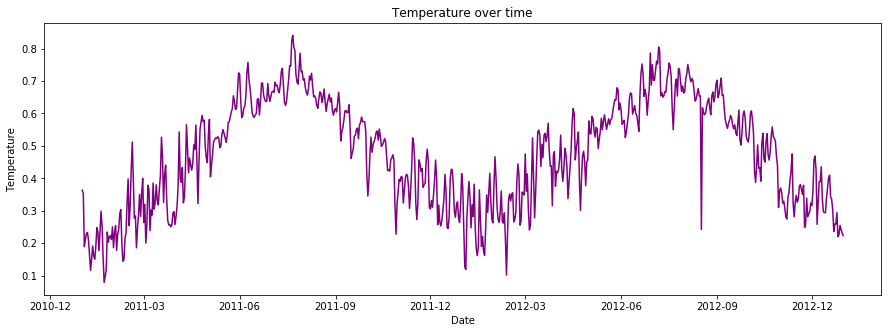

In [66]:
plt.figure(figsize=(15,5))

sns.lineplot(data = df_day, x = 'dteday', y = 'atemp', color = 'purple')

plt.title('Temperature over time')
plt.xlabel('Date')
plt.ylabel('Temperature')

plt.show()

In [67]:
df_hour_13['temp'] = df_hour[df_hour['mnth'] < 3]['temp'].mean()

In [68]:
X_val = df_hour_13[features]
Y_val = df_hour_13['cnt']

In [69]:
Yhat = pd.Series(final_model.predict(X_val), index = Y_val.index)

In [70]:
mean_absolute_error(Yhat, Y_val)

68.49327195467423

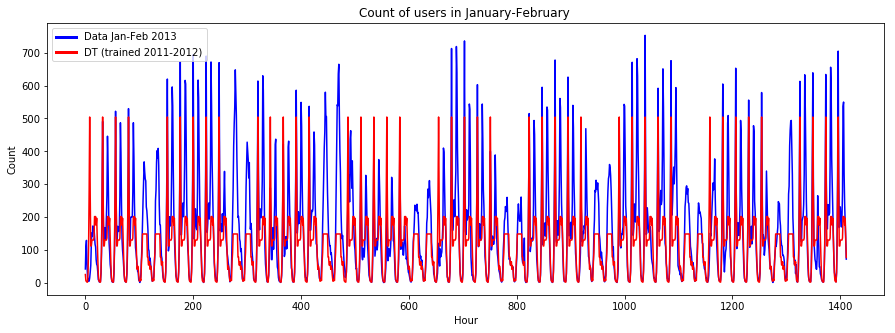

In [71]:
plt.figure(figsize=(15, 5))

sns.lineplot(data = Y_val, color = 'blue')
sns.lineplot(data = Yhat,color = 'red')

plt.title('Count of users in January-February ')
plt.xlabel('Hour')
plt.ylabel('Count')

labels = ['Data Jan-Feb 2013', 'DT (trained 2011-2012)']
colors = ['blue', 'red']
lines = [Line2D([0], [0], color = c, linewidth = 3, linestyle = '-') for c in colors]
plt.legend(lines, labels, loc = 'upper left')

plt.show()

As one can see from the `MAE` and the plot, the model performance is good, even though we have taken simplistic assumptions on the temperature and number of bike stations.

Regarding possible business usage, the model is dependent mostly on the data, easily obtainable and available for a possible client. The temperature is the only data, which is to be obtained externally. One could in in principle use one of many APIs, available on the market, (e.g. https://openweathermap.org/api) to get hourly temperture prediction. 